# Problem Set 3, due Wednesday, May 3rd, 5:30pm.

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz (available on Canvas).  The data
(progresa_sample.csv.gz) is available on canvas
in files/data.

Please read the paper to familiarize yourself with
the PROGRESA program before beginning this problem set, so you have a
rough sense of where the data come from and how they were
generated. If you just proceed into the problem set without
understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic
econometric techniques that you are learning in class to measure the
impact of Progresa on secondary school enrollment rates, in particular
differences-in-differences.  Your task is to **estimate the impact of
_progresa_ subsidies on the school attendance**.  Note: this asks to
estimate a causal effect.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from
Canvas. The data are actual data collected to evaluate the impact of
the Progresa program.  In this file, each row corresponds to an
observation taken for a given child for a given year. There are two
years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the
following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |treatment = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
# loading the data
pdf = pd.read_csv('../../data/progresa_sample.csv.gz')

#check the first couple of rows to see what's the data like
pdf.head()

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
0,97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,1,7,1.0
1,98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,14,163,1,7,1.0
2,97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,12,163,2,6,1.0
3,98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,2,6,1.0
4,97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,8,163,3,2,1.0


In [3]:
# check basic data information
print(pdf.shape)

(77250, 21)


## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Report summary statistics (mean, standard deviation, and number of missings) for all of
the demographic variables in the dataset (i.e., everything except
year, folnum, village).  Present the actual levels for 'progresa' and
'poor'.  Do these fit with the documentation above?

Present these in a single table alphabetized
by variable name. Do NOT simply expect the grader to scroll through
your output!

In [4]:
# drop the irrelevant variables year, folnum, village
pdf_cleaned = pdf.drop(['year','folnum','village'], axis=1)
pdf_cleaned.head()

,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,progresa,hohedu,hohwag,welfare_index,hohsex,hohage,age,grc97,sc97
0,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,13,7,1.0
1,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,14,7,1.0
2,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,12,6,1.0
3,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,13,6,1.0
4,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,8,2,1.0


##### SUMMARY OF STATS  and FIND THE NUMBER OF MISSINGS

In [5]:
# sum up the null values as number of missing
null_values = (pd.isnull(pdf_cleaned)).sum()
# add the levels for poor and progresa
actual_levels = {'pobre': 1, 'no pobre':0, 'basal': 1, '0': 0}
pdf_cleaned = pdf_cleaned.replace({'poor': actual_levels, 'progresa': actual_levels})

# transpose the array and keep only mean and standard deviation
p_summary = pdf_cleaned.describe().T[['mean','std']]

# order by index from a to z
p_summary = p_summary.sort_index()

# add the null value column
p_summary = p_summary.assign(null = null_values)

p_summary

,mean,std,null
age,11.366460,3.167744,0
dist_cap,147.674452,76.063134,0
dist_sec,2.418910,2.234109,0
fam_n,7.215715,2.352900,0
grc,3.963537,2.499063,6549
grc97,3.705372,2.572387,0
hohage,44.436717,11.620372,10
hohedu,2.768104,2.656106,0
hohsex,0.925185,0.263095,20
hohwag,586.985312,788.133664,0


yes it fit in within the documentation as it should be 0,1 values?

### 1.2 Differences at baseline?
Now let's investigate the differences in baseline.  Are the baseline (1997) demographic characteristics **for the poor**
different in treatment and control villages?

I suggest you to use a T-Test to
determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset. Focus only
on the data from 1997 for poor.

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [6]:
#### for the treatment group 
# define treatment group 97 + pobre + basal
df_t = pdf[(pdf.year == 97) & (pdf.poor == 'pobre') & (pdf.progresa == 'basal')]

# drop the unnecessary variables
df_t_mean = df_t.drop(['year','folnum','village'], axis=1).describe()

# transpose and sort by index
df_t_mean = df_t_mean.T[['mean']].sort_index()



#### for the control group
# treatment group 97 + pobre + basal
df_c = pdf[(pdf.year ==97) & (pdf.poor =='pobre') & (pdf.progresa =='0')]

# drop the unnecessary variables
df_c_mean = df_c.drop(['year','folnum','village'], axis=1).describe()

# transpose and sort by index
df_c_mean = df_c_mean.T[['mean']].sort_index()


# difference between control and treatment
df_difference = df_t_mean - df_c_mean

# Concatenate the df_t_mean, df_c_mean and df_difference into one dataframe
df_tcd = pd.concat([df_t_mean, df_c_mean, df_difference], axis=1) 
df_t_cleaned = df_t.dropna() # drop the rows with null values
df_c_cleaned = df_c.dropna() # drop the rows with null values

In [7]:
# Calulate p-value
plist = []
for row in range(df_tcd.shape[0]): # get the row number
    t,p = stats.ttest_ind(df_t_cleaned[df_tcd.index[row]], df_c_cleaned[df_tcd.index[row]])
    if p < 0.05:
        p = str(p) + '*' # Add a star to the pvalues that are smaller than 0.05
    plist.append(p)
plist

[0.24761554848946915,
 '0.00341419363605*',
 0.96709492010812692,
 0.4236087919095054,
 0.39477501418400196,
 0.39477501418400196,
 '1.92576696655e-06*',
 '0.0261323928686*',
 0.47812322422242826,
 '0.000272766085337*',
 0.11837601031859153,
 '1.93666097582e-18*',
 0.091179585973369434,
 0.091179585973369434,
 '0.0195696201717*',
 '0.000372404258997*']

In [8]:
# Consolidate the series into a dataframe
t_result = pd.DataFrame({'Average value (Treatment villages)': df_tcd.iloc[:, 0], \
                         'Average value (Control villages)': df_tcd.iloc[:, 1], \
                         'Difference (Treatment - Control)': df_tcd.iloc[:, 2], \
                         'p-value': plist})
t_result

,Average value (Control villages),Average value (Treatment villages),Difference (Treatment - Control),p-value
age,10.742023,10.716991,-0.025032,0.247616
dist_cap,153.769730,150.829074,-2.940656,0.00341419363605*
dist_sec,2.507662,2.453122,-0.054540,0.967095
fam_n,7.302469,7.281327,-0.021142,0.423609
grc,3.543050,3.531599,-0.011450,0.394775
grc97,3.543050,3.531599,-0.011450,0.394775
hohage,44.276918,43.648828,-0.628090,1.92576696655e-06*
hohedu,2.590348,2.663139,0.072791,0.0261323928686*
hohsex,0.922947,0.924656,0.001709,0.478123
hohwag,573.163558,544.339544,-28.824015,0.000272766085337*


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

##### Discussion
- A: as shown in the list, variables(dist_cap, hohage, hohedu, min_dist, sex, welfare_index) are statistically significant between treatment and control villages as baseline as they have a p value that is smaller than 0.05
- B: If there are differences at baseline, then the groups may not be randomly choosen. As experiments require the treament and control group to be randomly selected, we may have a hard time finding the causality of the treatment due to the non random selected groups
- C: As there are quite a few variables that have statistically significant differences between the treatment and the control villages as baseline, we need to further investigate the differences between the treatment and the control group by adding control variables.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average
enrollment rate in 1997. Create a scatterplot that shows this
relationship. What do you notice?

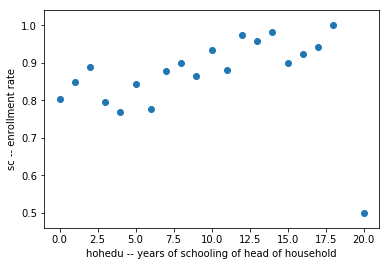

In [9]:
# finding the x and y for the graph
x = pdf.hohedu.unique()
y = pdf[(pdf.year == 97)].groupby('hohedu')['sc'].mean()

plt.scatter(x, y)
plt.xlabel('hohedu -- years of schooling of head of household')
plt.ylabel('sc -- enrollment rate')

##### Discussion
- as shown in the graph, as the years of schooling of head of household goes higher, the enrollment rate goes higher --> indicating that the higher educated household heads may care more about their children's enrollment in school. However, there is a sharp drop at the year of 20 years of schooling of head of household and this may be an outlier or it could be some other reasons.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households
in treated villages**, before and after treatment.  Specifically, for
each village, calculate the average rate of enrollment of poor
households in treated villages in 1997, then compute the average rate
of enrollment of poor households in treated villages in 1998. Create
two separate histograms showing the distribution of these average
enrollments rates, one histogram for 1997 and one histogram for
1998. On each histogram, draw a vertical line that intersects the
x-axis at the average value (across all households). Does there appear
to be a difference? Is this difference statistically significant?

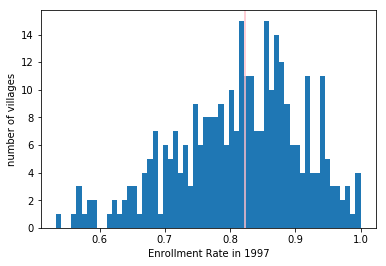

In [10]:
# for 1997 treatment group
#filter and leave only the poor treated in 1997
df_poor_97 = pdf[(pdf.poor == 'pobre') & (pdf.progresa == 'basal') & (pdf.year == 97)] 

# group by village
df_poor_97_group = df_poor_97.groupby('village')[['sc']].mean().reset_index() 

# get the mean of the enrollment rate of the poor treated in 1997
sc_mean_97 = df_poor_97['sc'].mean()

# plot the graph
plt.hist('sc', data=df_poor_97_group, bins = 60)
plt.xlabel('Enrollment Rate in 1997')
plt.ylabel('number of villages')
plt.axvline(sc_mean_97, color='pink')

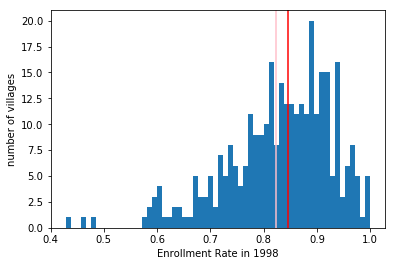

In [11]:
# for 1998 treatment group
#filter and leave only the poor treated in 1998
df_poor_98 = pdf[(pdf.poor == 'pobre') & (pdf.progresa == 'basal') & (pdf.year == 98)]

# group by village
df_poor_98_group = df_poor_98.groupby('village')[['sc']].mean().reset_index() 

# get the mean of the enrollment rate of the poor treated in 1998
sc_mean_98 = df_poor_98['sc'].mean()

# plot the graph
plt.hist('sc', data=df_poor_98_group, bins=60)
plt.xlabel('Enrollment Rate in 1998')
plt.ylabel('number of villages')
plt.axvline(sc_mean_98, color = 'red')
plt.axvline(sc_mean_97, color = 'pink')

In [12]:
# get the t test and p value for the 98 and 97 for comparison
t, p = stats.ttest_ind(df_poor_98_group['sc'], df_poor_97_group['sc'])
print (
    "sc mean for 1997: ", sc_mean_97, "\n" 
    "sc mean for 1997: ", sc_mean_98, "\n" 
    "t-value: ", t, "\n" 
    "p-value: ", p)

sc mean for 1997:  0.8226968874033842 
sc mean for 1997:  0.8464791213954308 
t-value:  2.01571348652 
p-value:  0.0442487003657


##### Discussion
- as shown in the graph, the mean for the enrollment rate experienced a slight shift towards aroudn 0.845 from 0.82, meaning that the enrollment rate does get slightly improved after the program is implemented
- p = 0.044 < 0.05 --> the result differences between the mean is statistically significant 

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor (those with
poor=='pobre'), since only the poor were eligible to receive the
PROGRESA assistance.

### 2.1 Cross-Sectional Estimator: T-test

Begin by estimating the impact of Progresa using "simple differences."
Restricting yourself to data from 1998 (after treatment), calculate
the average enrollment rate among **poor** households in the Treatment
villages and the average enrollment rate among **poor** households in
the control villages. Use a t-test to determine if this difference is
statistically significant. What do you conclude?

In [13]:
# create df of the poor with treatment and the poor in control in the year of 1998
df_tpoor = pdf[((pdf.poor == 'pobre') & (pdf.progresa == 'basal') & (pdf.year == 98))] 
df_cpoor = pdf[((pdf.poor == 'pobre') & (pdf.progresa == '0') & (pdf.year == 98))] 

# get the average enrollment of the treatment and the control group
df_tpoor_mean = df_tpoor.sc.mean()
df_cpoor_mean = df_cpoor.sc.mean()

# conducting t test
t_test_98 = stats.ttest_ind(df_tpoor.sc.dropna(), df_cpoor.sc.dropna())
t_test_98

# print result
print("average enrollment rate among poor households in the Treatment villages: ", round(float(df_tpoor_mean)*100,2), "%", "\n", 
      "average enrollment rate among poor households in the control villages: ", round(float(df_cpoor_mean)*100,2), "%", "\n", 
      "t-test and p-value: ", t_test_98,"\n", 
    "difference between treatment mean and control mean: ", (df_tpoor_mean - df_cpoor_mean) 
)

average enrollment rate among poor households in the Treatment villages:  84.65 % 
 average enrollment rate among poor households in the control villages:  80.76 % 
 t-test and p-value:  Ttest_indResult(statistic=8.3587205674183735, pvalue=6.636344447523235e-17) 
 difference between treatment mean and control mean:  0.0388421646651228


##### Discussion
- avg enrollment rate increased by around 4%
- p value is much smaller than 0.05 --> meaning that the difference is statistically significant aka the treatment group progress is working very well 

### 2.2 Cross-Sectional Estimator: Regression

Estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
treatment assignment.  Do not include any additional control
variables.
Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

Note: I recommend to use statsmodels.formula.api as this allows to use
convenient R-style formulas and provedes nice summaries of the results.

In [14]:
# clean the data so only work with data that do not contain null values
pdf_cl = pdf.dropna()

# getting only the data that is in poor and in the year of 98
pdf_cl = pdf_cl[((pdf_cl.poor == 'pobre') & (pdf_cl.year == 98))]

# assign treament group for progresa = 1 
# assign control group for progresa = 0
progresa = pd.get_dummies(pdf_cl, columns=['progresa'])
progresa

# getting only the columns we need for the single variable regression
sregre_df = progresa[['poor', 'year', 'sc', 'progresa_0', 'progresa_basal']]
sregre_df

# run single variable linear regression
ols_sg = smf.ols(formula='sc ~ progresa_basal', data = sregre_df).fit()
ols_sg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     65.64
Date:                Tue, 08 May 2018   Prob (F-statistic):           5.66e-16
Time:                        14:42:35   Log-Likelihood:                -11171.
No. Observations:               26155   AIC:                         2.235e+04
Df Residuals:                   26153   BIC:                         2.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8109      0.004    217.190      0.000       0.804       0.818
progresa_basal     0.0383      0.005      8.102      0.000       0.029       0.048
==============================================================================
Omnibus:                     7487.800   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15756.374
Skew:                          -1.796   Prob(JB):                         0.00
Kurtosis:                       4.245   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Discussion
__Based on this model, how much did Progresa increase the likelihood of a child enrolling?__
- as seen in the OLS regression results, the coefficient for the progresa_basal is 0.0383 --> meaning that the likelihood of the kids enrolling rate increased by 0.0383 per unit after the program is pushed to action <br>

__How does your regression estimate compare to your t-test estimate from part 2.1?__
- the slope 0.0383 is very close to the difference between treatment mean and control mean got in 2.1 --> which indicates that when a village get the progresa program, its enrollment rate will increase by around 0.0388 <br>

__Based on this regression model, can we reject the null hypothesis that the treatment effects are zero?__ 
- p value is 0.000 which is way smaller than 0.05 --> indicating a statistically siggnificant result --> null hypothesis can be rejected<br>

__What is the counterfactual assumption underlying this regression?__
- counterfactual: has not exist the progresa program, the enrollment of the poor children in the villages would have been the same for both control and treatment group<br>

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of
relevant control variables. Include, for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [15]:
# getting the cleaned progresa df for the multi variable regression
mregre_df = progresa

# run multivariable linear regression
ols_mul = smf.ols(formula='sc ~ age + dist_sec + sex + hohedu + welfare_index + indig + progresa_basal', data = mregre_df).fit()
ols_mul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     1335.
Date:                Tue, 08 May 2018   Prob (F-statistic):               0.00
Time:                        14:42:35   Log-Likelihood:                -7207.0
No. Observations:               26155   AIC:                         1.443e+04
Df Residuals:                   26147   BIC:                         1.450e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5025      0.015    103.473      0.000       1.474       1.531
age               -0.0651      0.001    -92.275      0.000      -0.066      -0.064
dist_sec          -0.0108      0.001    -11.585      0.000      -0.013      -0.009
sex                0.0308      0.004      7.799      0.000       0.023       0.039
hohedu             0.0081      0.001     10.185      0.000       0.007       0.010
welfare_index   2.907e-05   1.75e-05      1.663      0.096    -5.2e-06    6.33e-05
indig              0.0498      0.004     11.757      0.000       0.041       0.058
progresa_basal     0.0351      0.004      8.630      0.000       0.027       0.043
==============================================================================
Omnibus:                     3018.892   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4177.185
Skew:                          -0.968   Prob(JB):                         0.00
Kurtosis:                       3.293   Cond. No.                     4.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Discussion
__How do the controls affect the point estimate of treatment effect?__
- as the slope of progresa_basal decreased from 0.0388 to 0.0351 --> the control negatively affected the point estimate of treatment effect <br>

__How do the controls affect the standard error on the treatment effect?__
- 0.005 --> 0.004 negatively affect sd <br>

__How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?__ 
- the correlation coefficient decreases after more variables are introduced, this could mean that the newly-introduced variables are some how correlated to the y variable which is sc. We may need to further investigate other variable's influence on the enrollment rate.<br>


### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the
difference in 1998 enrollment rates across villages. An alternative
approach would be to compute the treatment effect using a
difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

* What is the counterfactual assumption underlying this estimate? 


In [16]:
# treated group
df_t_97 = (pdf[((pdf.year==97)&(pdf.poor =='pobre')&(pdf.progresa == 'basal'))]['sc'].mean())
df_t_98 = (pdf[((pdf.year==98)&(pdf.poor =='pobre')&(pdf.progresa == 'basal'))]['sc'].mean())
# difference between treated groups result from 97 and 98
t_differ = df_t_98 - df_t_97

# control group
df_c_97 = (pdf[((pdf.year==97)&(pdf.poor =='pobre')&(pdf.progresa == '0'))]['sc'].mean())
df_c_98 = (pdf[((pdf.year==98)&(pdf.poor =='pobre')&(pdf.progresa == '0'))]['sc'].mean())
# difference between treated groups result from 97 and 98
c_differ = df_c_98 - df_c_97

#diff-in-diff
diff_in_diff = t_differ - c_differ

print("difference in treated group: ", t_differ, "\n", 
      "difference in control group: ", c_differ, "\n",
      "diff-in-diff: ", diff_in_diff)


difference in treated group:  0.023782233992046597 
 difference in control group:  -0.007549046327276487 
 diff-in-diff:  0.031331280319323085


##### Discussion
__What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?__
- diff-in-diff is 0.031 --> similar to the slope of 0.038 but slightly smaller <br>

__What is the counterfactual assumption underlying this estimate?__
- counterfactual: the avg change btw treatment and control would have been 0 without the treatment <br>


### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment
effects of the program in a difference-in-differences
framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in
  interpreting your coefficients and standard errors, and make sure to
  specify exactly what units you are measuring and estimating.

* How do these estimates of the treatment effect compare to the
  estimates based on the simple difference?

* How do these estimates compare to the difference-in-difference
  estimates from 2.4 above? What accounts for these differences?

* What is the counterfactual assumption underlying this regression? 

In [17]:
# drop null values
diff_diff_ols = pdf.dropna()

diff_ols = smf.ols(formula='sc ~ progresa*C(year) + age + dist_sec + sex + hohedu + welfare_index + indig', data = diff_diff_ols).fit()
diff_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2880.
Date:                Tue, 08 May 2018   Prob (F-statistic):               0.00
Time:                        14:42:35   Log-Likelihood:                -19910.
No. Observations:               67122   AIC:                         3.984e+04
Df Residuals:                   67112   BIC:                         3.993e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.4590      0.008    172.731      0.000       1.442       1.476
progresa[T.basal]                   0.0081      0.004      2.317      0.020       0.001       0.015
C(year)[T.98]                       0.0340      0.004      8.303      0.000       0.026       0.042
progresa[T.basal]:C(year)[T.98]     0.0259      0.005      4.994      0.000       0.016       0.036
age                                -0.0658      0.000   -153.853      0.000      -0.067      -0.065
dist_sec                           -0.0109      0.001    -18.182      0.000      -0.012      -0.010
sex                                 0.0330      0.003     13.132      0.000       0.028       0.038
hohedu                              0.0077      0.000     16.029      0.000       0.007       0.009
welfare_index                    5.669e-05   9.31e-06      6.087      0.000    3.84e-05    7.49e-05
indig                               0.0506      0.003     18.145      0.000       0.045       0.056
==============================================================================
Omnibus:                     6008.376   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7802.566
Skew:                          -0.835   Prob(JB):                         0.00
Kurtosis:                       3.008   Cond. No.                     4.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Discussion
__What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.__
- the coefficient of the diff-diff regression is 0.0259	with a sd of 0.005 --> meaning that the the likelihood of the children's avg enrollment increases by 0.0259 after the program is implemented <br>

__How do these estimates of the treatment effect compare to the estimates based on the simple difference?__
- the diff-in-diff method considers both the before and after effect of the program while the simple diff method only considers the after effect. Therefore, we can better estimate the actual effect of the treatment because the way we look at it is more holistic <br>

__How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?__
- the value decreases from 0.031 in simple diff to 0.0259 in diff-in-diff. here we also took other variables, such as age, dist_sec, sex, hohedu, welfare_index, indig into the regression so the result may be influenced by these other variables<br>

__What is the counterfactual assumption underlying this regression?__
- counterfactual: the diff-in-diff would have been 0 if no progresa treatment is implemented <br>

### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you
  believe that Progresa had a causal impact on the enrollment rates of
  poor households in Mexico?  Explain by referring to the methods and
  results above.

##### Discussion
- in summary I think the the progresa program had a casual impact on the enrollment rates of poor households in Mexico. Although there is a slight difference in the treatment and control groups' samples, the program is randomly assigned and we can tell from both SLR, MLR and diff-in-diff method that there is a ~3% increase in the enrollment rate for those who are in the treatment group. Both p values and t tests are showing statistically significant results so we can conclude that the program had a good impact.